<a href="https://colab.research.google.com/github/Ismatulsyantik/monkeypox-prediction-/blob/main/MONKEYPOX_PREDITCION_CONSTANipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Preprocessing: Import libraries untuk analisis, visualisasi, dan preprocessing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 2. Pemodelan: Import model untuk klasifikasi
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 3. Penanganan Imbalanced Data: Menggunakan SMOTE dan ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter


# JADI DI SINI ADA 5 **pemodelan**

# **DATA ANALISIS**

In [ ]:
dataset = pd.read_csv('/content/Monkeypox.csv', delimiter=';')
dataset.head()
dataset.columns

Index(['ID', 'Status', 'Location', 'City', 'Country', 'Age', 'Gender',
       'Date_onset', 'Date_confirmation', 'Symptoms', 'Hospitalised (Y/N/NA)',
       'Date_hospitalisation', 'Isolated (Y/N/NA)', 'Date_isolation',
       'Outcome', 'Contact_comment', 'Contact_ID', 'Contact_location',
       'Travel_history (Y/N/NA)', 'Travel_history_entry',
       'Travel_history_start', 'Travel_history_location',
       'Travel_history_country', 'Genomics_Metadata', 'Confirmation_method',
       'Source', 'Source_II', 'Date_entry', 'Date_last_modified', 'Source_III',
       'Country_ISO3'],
      dtype='object')

In [ ]:
unique_values_all = dataset.apply(lambda x: x.unique())
print(unique_values_all)

ID                         [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
Status                                [confirmed, discarded, suspected, nan]
Location                   [Guy's and St Thomas Hospital London, London, ...
City                       [London, Newcastle, Lisbon, nan, South East, M...
Country                    [England, Portugal, nan, Spain, Sweden, Canada...
Age                        [nan, 20-44, 30-59, 25-29, 30-34, 40-49, 30-39...
Gender                                      [nan, male, female, Male, male ]
Date_onset                 [29/04/2022, 05/05/2022, 30/04/2022, nan, 09/0...
Date_confirmation          [06/05/2022, 12/05/2022, 13/05/2022, 15/05/202...
Symptoms                   [rash, vesicular rash, skin lesions, ulcerativ...
Hospitalised (Y/N/NA)                                            [Y, N, nan]
Date_hospitalisation       [04/05/2022, 06/05/2022, nan, 20/05/2022, 22/0...
Isolated (Y/N/NA)                                                   [Y, nan]

In [ ]:
null_counts = dataset.isnull().sum()
total_rows = len(dataset)
null_percentage = (null_counts / total_rows) * 100

# Membuat DataFrame untuk menampilkan hasil
null_summary = pd.DataFrame({
    'Jumlah Null': null_counts,
    'Persentase Null (%)': null_percentage
}).sort_values(by='Persentase Null (%)', ascending=False)

# Menampilkan hasil
print(null_summary)


                         Jumlah Null  Persentase Null (%)
Travel_history_start            1132            99.911739
Outcome                         1132            99.911739
Contact_location                1130            99.735216
Date_hospitalisation            1128            99.558694
Travel_history_entry            1128            99.558694
Contact_ID                      1128            99.558694
Date_isolation                  1127            99.470432
Date_onset                      1127            99.470432
Contact_comment                 1118            98.676081
Genomics_Metadata               1116            98.499559
Travel_history_location         1115            98.411297
Travel_history_country          1112            98.146514
Source_III                      1097            96.822595
Confirmation_method             1059            93.468667
Isolated (Y/N/NA)               1058            93.380406
Hospitalised (Y/N/NA)           1047            92.409532
Symptoms      

In [ ]:
dataset['Status'] = dataset['Status'].fillna(dataset['Status'].mode()[0])
dataset['Status'].unique()

array(['confirmed', 'discarded', 'suspected'], dtype=object)

In [ ]:
dataset['Status'].value_counts()

,count
Status,
confirmed,921
discarded,145
suspected,67


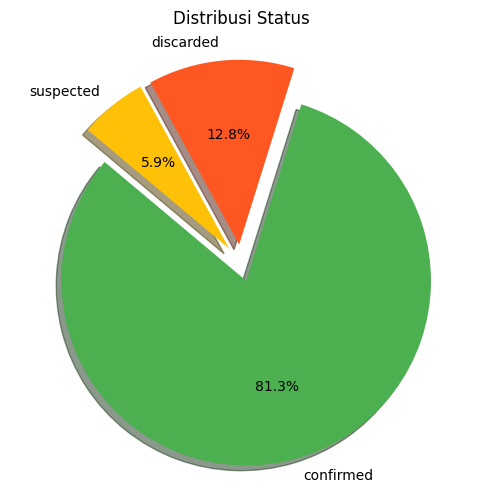

In [ ]:
status_counts = dataset['Status'].value_counts()

# Pie chart
plt.figure(figsize=(8, 6))
colors = ['#4CAF50', '#FF5722', '#FFC107']  # Warna untuk tiap kategori
status_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=(0.1, 0.1, 0.1),  # Memisahkan setiap slice
    shadow=True
)
plt.title('Distribusi Status')
plt.ylabel('')  # Menghapus label sumbu Y
plt.show()

# **PREPROCESSING**

mengganti data age dari rentang dengan numerik

In [ ]:

def convert_age_to_numeric(Age):
    if pd.isnull(Age):
        return np.nan  # Tetap NaN untuk nilai kosong
    if isinstance(Age, str):  # Pastikan nilai berupa string
        Age = Age.strip()
        if Age == 'Oct-14' or Age == 'CAN':
            return np.nan  # Anggap 'Oct-14' dan 'CAN' sebagai NaN karena tidak sesuai format usia
        if Age == '<40':
            return 20  # Ganti '<40' menjadi 20 (setengah dari 40)
        if '-' in Age:
            # Hitung rata-rata rentang usia, misalnya '20-44' menjadi (20+44)/2
            low, high = Age.split('-')
            return (float(low) + float(high)) / 2
    return np.nan  # Format lainnya dianggap NaN

# Terapkan fungsi hanya pada kolom 'Age'
dataset['Age'] = dataset['Age'].apply(convert_age_to_numeric)

# Menampilkan dataset setelah pemrosesan

# **MENGHAPUS KOLOM YANG TIDAK RELEVAN**

In [ ]:
dataset.drop(columns=['Genomics_Metadata', 'Source', 'Source_II', 'Source_III', 'ID','Travel_history_start'], inplace=True)
dataset.columns

Index(['Status', 'Location', 'City', 'Country', 'Age', 'Gender', 'Date_onset',
       'Date_confirmation', 'Symptoms', 'Hospitalised (Y/N/NA)',
       'Date_hospitalisation', 'Isolated (Y/N/NA)', 'Date_isolation',
       'Outcome', 'Contact_comment', 'Contact_ID', 'Contact_location',
       'Travel_history (Y/N/NA)', 'Travel_history_entry',
       'Travel_history_location', 'Travel_history_country',
       'Confirmation_method', 'Date_entry', 'Date_last_modified',
       'Country_ISO3'],
      dtype='object')

# **MELABEL ENCODING**

In [ ]:
from sklearn.preprocessing import LabelEncoder


categorical_columns = [
    'Status', 'Location', 'City', 'Country', 'Gender', 'Symptoms',
    'Hospitalised (Y/N/NA)', 'Isolated (Y/N/NA)', 'Outcome', 'Contact_comment',
    'Contact_location', 'Travel_history (Y/N/NA)', 'Travel_history_location',
    'Travel_history_country', 'Confirmation_method','Country_ISO3'
]

label_encoder = LabelEncoder()

for col in categorical_columns:
    if col in dataset.columns:
        dataset[col] = label_encoder.fit_transform(dataset[col].astype(str))

print(dataset.head())

   Status  Location  City  Country  Age  Gender  Date_onset Date_confirmation  \
0       0        46    27       12  NaN       4  29/04/2022        06/05/2022   
1       0        46    27       12  NaN       4  05/05/2022        12/05/2022   
2       0        58    27       12  NaN       4  30/04/2022        13/05/2022   
3       0        58    27       12  NaN       2         NaN        15/05/2022   
4       0        58    27       12  NaN       2         NaN        15/05/2022   

   Symptoms  Hospitalised (Y/N/NA)  ... Contact_ID  Contact_location  \
0        13                      1  ...        NaN                 1   
1        13                      1  ...        3.0                 0   
2        17                      0  ...        2.0                 0   
3        17                      1  ...        NaN                 1   
4        17                      1  ...        NaN                 1   

  Travel_history (Y/N/NA)  Travel_history_entry  Travel_history_location  \
0   

# **MENGUBAH TANGGAL MENJADI numerik**

In [ ]:
# Daftar kolom yang ingin diproses
date_columns = [
    'Date_onset', 'Date_confirmation', 'Date_hospitalisation',
    'Date_isolation','Date_entry', 'Date_last_modified','Travel_history_entry'
]

def convert_date_to_numeric(date):
    if pd.isnull(date):
        return np.nan
    date = pd.to_datetime(date, errors='coerce', dayfirst=True)
    if pd.isnull(date):
        return np.nan
    return (date - pd.Timestamp('1970-01-01')).days
for col in date_columns:
    dataset[col] = dataset[col].apply(convert_date_to_numeric)



# **HANDELING NULL VALUE DENGAN CONSTANT**

In [ ]:

numerical_columns = ['Location', 'City', 'Country', 'Age', 'Gender', 'Date_onset',
                     'Date_confirmation', 'Symptoms', 'Hospitalised (Y/N/NA)', 'Date_hospitalisation',
                     'Isolated (Y/N/NA)', 'Date_isolation', 'Outcome', 'Contact_comment', 'Contact_ID',
                     'Contact_location', 'Travel_history (Y/N/NA)', 'Travel_history_entry',
                      'Travel_history_location', 'Travel_history_country',
                     'Confirmation_method', 'Date_entry', 'Date_last_modified', 'Country_ISO3']


numerical_columns = [col for col in numerical_columns if col in dataset.columns]
columns_with_nan = dataset[numerical_columns].isna().sum()
columns_with_nan = columns_with_nan[columns_with_nan == len(dataset)]  # Columns with only NaN values
print(f"Columns with all missing values: {columns_with_nan.index.tolist()}")

numerical_columns = [col for col in numerical_columns if col not in columns_with_nan.index]

# Apply SimpleImputer to fill missing values with the mean for numerical columns
imputer = SimpleImputer(strategy='constant')
dataset[numerical_columns] = imputer.fit_transform(dataset[numerical_columns])
 #{'mean', 'constant', 'median', 'most_frequent'}

print(dataset.head())
print(dataset.isnull().sum())


dataset.to_csv("preprocessing_monkeypox.csv", index=False)
print("Dataset yang telah diolah berhasil disimpan.")






Columns with all missing values: []
   Status  Location  City  Country  Age  Gender  Date_onset  \
0       0      46.0  27.0     12.0  0.0     4.0     19111.0   
1       0      46.0  27.0     12.0  0.0     4.0     19117.0   
2       0      58.0  27.0     12.0  0.0     4.0     19112.0   
3       0      58.0  27.0     12.0  0.0     2.0         0.0   
4       0      58.0  27.0     12.0  0.0     2.0         0.0   

   Date_confirmation  Symptoms  Hospitalised (Y/N/NA)  ...  Contact_ID  \
0            19118.0      13.0                    1.0  ...         0.0   
1            19124.0      13.0                    1.0  ...         3.0   
2            19125.0      17.0                    0.0  ...         2.0   
3            19127.0      17.0                    1.0  ...         0.0   
4            19127.0      17.0                    1.0  ...         0.0   

   Contact_location  Travel_history (Y/N/NA)  Travel_history_entry  \
0               1.0                      1.0               19116.0   


In [ ]:
df = pd.read_csv('/content/preprocessing_monkeypox.csv')
df.head()

,Status,Location,City,Country,Age,Gender,Date_onset,Date_confirmation,Symptoms,Hospitalised (Y/N/NA),...,Contact_ID,Contact_location,Travel_history (Y/N/NA),Travel_history_entry,Travel_history_location,Travel_history_country,Confirmation_method,Date_entry,Date_last_modified,Country_ISO3
0,0,46.0,27.0,12.0,0.0,4.0,19111.0,19118.0,13.0,1.0,...,0.0,1.0,1.0,19116.0,5.0,6.0,2.0,19130.0,19130.0,14.0
1,0,46.0,27.0,12.0,0.0,4.0,19117.0,19124.0,13.0,1.0,...,3.0,0.0,0.0,0.0,12.0,11.0,2.0,19130.0,19130.0,14.0
2,0,58.0,27.0,12.0,0.0,4.0,19112.0,19125.0,17.0,0.0,...,2.0,0.0,0.0,0.0,12.0,11.0,2.0,19130.0,19130.0,14.0
3,0,58.0,27.0,12.0,0.0,2.0,0.0,19127.0,17.0,1.0,...,0.0,1.0,0.0,0.0,12.0,11.0,3.0,19130.0,19130.0,14.0
4,0,58.0,27.0,12.0,0.0,2.0,0.0,19127.0,17.0,1.0,...,0.0,1.0,0.0,0.0,12.0,11.0,3.0,19130.0,19130.0,14.0


# **SPLITING DATA SET**
Memisahkan data menjadi train dan test (80% training, 20% testing)

In [ ]:



X = df.drop(columns=['Status'])
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# **FEATUR SCALING DENGAN STANDARISASI**

In [ ]:


scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_normalized = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
print(X_train_normalized.head())



   Location      City   Country       Age    Gender  Date_onset  \
0  0.748893  0.521880 -0.923347 -0.369285  0.546616   -0.074494   
1 -0.583359  0.192845 -1.481002 -0.369285  0.546616   -0.074494   
2 -1.312926 -1.715559  0.610205  2.139808 -1.762167   -0.074494   
3  0.653732  0.521880 -0.295985 -0.369285  0.546616   -0.074494   
4  0.653732 -1.386523  0.819325 -0.369285  0.546616   -0.074494   

   Date_confirmation  Symptoms  Hospitalised (Y/N/NA)  Date_hospitalisation  \
0           0.578172 -0.035902               0.283936             -0.066593   
1          -1.729505 -0.035902               0.283936             -0.066593   
2           0.576966  3.660335               0.283936             -0.066593   
3           0.578654 -0.035902               0.283936             -0.066593   
4           0.578051 -0.035902               0.283936             -0.066593   

   ...  Contact_ID  Contact_location  Travel_history (Y/N/NA)  \
0  ...   -0.047075               0.0                 0.28

# **MODEL SETELAH PREPROCESSING DENGAN CONSTAN**

In [ ]:

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for model_name, model in models.items():
    # Melatih model
    model.fit(X_train_normalized, y_train)

    # Membuat prediksi
    y_pred = model.predict(X_test_normalized)

    # Menampilkan dan menyimpan confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Print confusion matrix dan classification report
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

    # Menyimpan F1, Precision, Recall untuk setiap kelas
    result = {
    "Model": model_name,
    "Accuracy": cr["accuracy"],
    "F1 Class 0": cr["0"]["f1-score"],
    "Precision Class 0": cr["0"]["precision"],
    "Recall Class 0": cr["0"]["recall"],
    "Support Class 0": cr["0"]["support"],
    "F1 Class 1": cr["1"]["f1-score"],
    "Precision Class 1": cr["1"]["precision"],
    "Recall Class 1": cr["1"]["recall"],
    "Support Class 1": cr["1"]["support"],
    "F1 Macro Avg": cr["macro avg"]["f1-score"],
    "Precision Macro Avg": cr["macro avg"]["precision"],
    "Recall Macro Avg": cr["macro avg"]["recall"],
    "F1 Weighted Avg": cr["weighted avg"]["f1-score"],
    "Precision Weighted Avg": cr["weighted avg"]["precision"],
    "Recall Weighted Avg": cr["weighted avg"]["recall"]

}
    # Menambahkan hasil untuk model ini ke list
    results.append(result)

# Mengubah list menjadi DataFrame
df_results = pd.DataFrame(results)

# Menyimpan DataFrame ke dalam file CSV
df_results.to_csv('model_results_constan.csv', index=False)

print("Hasil telah disimpan di model_results.csv")

KNN Confusion Matrix:
[[184   0   1]
 [  3  24   2]
 [  5   1   7]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       185
           1       0.96      0.83      0.89        29
           2       0.70      0.54      0.61        13

    accuracy                           0.95       227
   macro avg       0.87      0.79      0.82       227
weighted avg       0.94      0.95      0.94       227

------------------------------------------------------------
Naive Bayes Confusion Matrix:
[[167   0  18]
 [  0   3  26]
 [  0   0  13]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       185
           1       1.00      0.10      0.19        29
           2       0.23      1.00      0.37        13

    accuracy                           0.81       227
   macro avg       0.74      0.67      0.50       227
weighted avg       0.96   

# **FEATURE ENGGENERING FEATURE SELECTION ENSAMBEL LEARNING FEATURE IMPORTACE WITH TRESHOLD**

In [ ]:

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_normalized, y_train)

# Mengambil nilai feature importance
importances = rf.feature_importances_


if isinstance(X_train_normalized, pd.DataFrame):
    feature_names = X_train_normalized.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_train_normalized.shape[1])]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)


threshold = 0.01
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature']
print("\nSelected Features:")
print(selected_features.tolist())


Feature Importances:
                    Feature  Importance
6         Date_confirmation    0.366972
0                  Location    0.161551
21               Date_entry    0.105651
2                   Country    0.101880
22       Date_last_modified    0.100514
23             Country_ISO3    0.067034
1                      City    0.035330
4                    Gender    0.014491
16  Travel_history (Y/N/NA)    0.011163
3                       Age    0.007170
10        Isolated (Y/N/NA)    0.006912
7                  Symptoms    0.005924
19   Travel_history_country    0.004194
8     Hospitalised (Y/N/NA)    0.003047
20      Confirmation_method    0.002812
13          Contact_comment    0.002366
5                Date_onset    0.001387
14               Contact_ID    0.001121
18  Travel_history_location    0.000364
11           Date_isolation    0.000053
17     Travel_history_entry    0.000037
15         Contact_location    0.000026
9      Date_hospitalisation    0.000002
12                 

In [ ]:
# Memilih fitur yang dipilih berdasarkan selected_features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Menampilkan bentuk data untuk memastikan seleksi fitur berhasil
print(f"Shape of X_train_selected: {X_train_selected.shape}")
print(f"Shape of X_test_selected: {X_test_selected.shape}")



Shape of X_train_selected: (906, 9)
Shape of X_test_selected: (227, 9)


# *MODEL SETELAH FITUR ENGGENERING*

In [ ]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for model_name, model in models.items():

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Print confusion matrix dan classification report
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

    # Menyimpan F1, Precision, Recall untuk setiap kelas
    result = {
    "Model": model_name,
    "Accuracy": cr["accuracy"],
    "F1 Class 0": cr["0"]["f1-score"],
    "Precision Class 0": cr["0"]["precision"],
    "Recall Class 0": cr["0"]["recall"],
    "Support Class 0": cr["0"]["support"],
    "F1 Class 1": cr["1"]["f1-score"],
    "Precision Class 1": cr["1"]["precision"],
    "Recall Class 1": cr["1"]["recall"],
    "Support Class 1": cr["1"]["support"],
    "F1 Macro Avg": cr["macro avg"]["f1-score"],
    "Precision Macro Avg": cr["macro avg"]["precision"],
    "Recall Macro Avg": cr["macro avg"]["recall"],
    "F1 Weighted Avg": cr["weighted avg"]["f1-score"],
    "Precision Weighted Avg": cr["weighted avg"]["precision"],
    "Recall Weighted Avg": cr["weighted avg"]["recall"]

}

    # Menambahkan hasil untuk model ini ke list
    results.append(result)

# Mengubah list menjadi DataFrame
df_results = pd.DataFrame(results)

# Menyimpan DataFrame ke dalam file CSV
df_results.to_csv('model_results_constan_feature_importance.csv', index=False)

print("Hasil telah disimpan di model_results_constan.csv")


KNN Confusion Matrix:
[[184   0   1]
 [  1  26   2]
 [  4   3   6]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       185
           1       0.90      0.90      0.90        29
           2       0.67      0.46      0.55        13

    accuracy                           0.95       227
   macro avg       0.85      0.78      0.81       227
weighted avg       0.95      0.95      0.95       227

------------------------------------------------------------
Naive Bayes Confusion Matrix:
[[167   0  18]
 [  1  26   2]
 [  0   4   9]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       185
           1       0.87      0.90      0.88        29
           2       0.31      0.69      0.43        13

    accuracy                           0.89       227
   macro avg       0.72      0.83      0.75       227
weighted avg       0.94   

# **IMBALANCE DENGAN SMOTE**

In [ ]:

# Oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Menampilkan distribusi label setelah SMOTE
print("Distribusi Label Setelah SMOTE:", Counter(y_train_smote))


Distribusi Label Setelah SMOTE: Counter({0: 736, 2: 736, 1: 736})


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# **MODEL DENGAN SMOTE**

In [ ]:

# Oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# Menampilkan distribusi label setelah SMOTE
print("Distribusi Label Setelah SMOTE:", Counter(y_train_smote))

# Mendefinisikan model
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for model_name, model in models.items():
    # Melatih model dengan data yang sudah oversampled
    model.fit(X_train_smote, y_train_smote)

    # Membuat prediksi
    y_pred = model.predict(X_test_selected)

    # Menampilkan dan menyimpan confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Print confusion matrix dan classification report
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

    # Menyimpan F1, Precision, Recall untuk setiap kelas
    result = {
    "Model": model_name,
    "Accuracy": cr["accuracy"],
    "F1 Class 0": cr["0"]["f1-score"],
    "Precision Class 0": cr["0"]["precision"],
    "Recall Class 0": cr["0"]["recall"],
    "Support Class 0": cr["0"]["support"],
    "F1 Class 1": cr["1"]["f1-score"],
    "Precision Class 1": cr["1"]["precision"],
    "Recall Class 1": cr["1"]["recall"],
    "Support Class 1": cr["1"]["support"],
    "F1 Macro Avg": cr["macro avg"]["f1-score"],
    "Precision Macro Avg": cr["macro avg"]["precision"],
    "Recall Macro Avg": cr["macro avg"]["recall"],
    "F1 Weighted Avg": cr["weighted avg"]["f1-score"],
    "Precision Weighted Avg": cr["weighted avg"]["precision"],
    "Recall Weighted Avg": cr["weighted avg"]["recall"]

}
    # Menambahkan hasil untuk model ini ke list
    results.append(result)

# Mengubah list menjadi DataFrame
df_results = pd.DataFrame(results)

# Menyimpan DataFrame ke dalam file CSV
df_results.to_csv('model_results_constan_feature_importance_smote.csv', index=False)

print("Hasil telah disimpan di model_results_constan_feature_importance.csv")


Distribusi Label Setelah SMOTE: Counter({0: 736, 2: 736, 1: 736})
KNN Confusion Matrix:
[[177   2   6]
 [  0  28   1]
 [  2   2   9]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       185
           1       0.88      0.97      0.92        29
           2       0.56      0.69      0.62        13

    accuracy                           0.94       227
   macro avg       0.81      0.87      0.84       227
weighted avg       0.95      0.94      0.95       227

------------------------------------------------------------
Naive Bayes Confusion Matrix:
[[167   0  18]
 [  1  25   3]
 [  0   1  12]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       185
           1       0.96      0.86      0.91        29
           2       0.36      0.92      0.52        13

    accuracy                           0.90       227
   macro avg  

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Random Forest Confusion Matrix:
[[180   1   4]
 [  0  27   2]
 [  0   2  11]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       185
           1       0.90      0.93      0.92        29
           2       0.65      0.85      0.73        13

    accuracy                           0.96       227
   macro avg       0.85      0.92      0.88       227
weighted avg       0.97      0.96      0.96       227

------------------------------------------------------------
Hasil telah disimpan di model_results_constan_feature_importance.csv


# **MODEL DENGAN CLASS WEIGHT**

In [ ]:

# Distribusi kelas dan class weights
class_weights = {0: 0.4099, 1: 2.6054, 2: 5.6429}

# Model dengan class weighting manual (hapus class_weight dari KNN dan Naive Bayes)
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(class_weight=class_weights, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight=class_weights, random_state=42)
}

results = []

for model_name, model in models.items():
    # Memilih fitur yang dipilih berdasarkan selected_features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Melatih model
    model.fit(X_train_selected, y_train)

    # Membuat prediksi
    y_pred = model.predict(X_test_selected)

    # Menampilkan dan menyimpan confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Print confusion matrix dan classification report
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

    # Menyimpan F1, Precision, Recall untuk setiap kelas
    result = {
    "Model": model_name,
    "Accuracy": cr["accuracy"],
    "F1 Class 0": cr["0"]["f1-score"],
    "Precision Class 0": cr["0"]["precision"],
    "Recall Class 0": cr["0"]["recall"],
    "Support Class 0": cr["0"]["support"],
    "F1 Class 1": cr["1"]["f1-score"],
    "Precision Class 1": cr["1"]["precision"],
    "Recall Class 1": cr["1"]["recall"],
    "Support Class 1": cr["1"]["support"],
    "F1 Macro Avg": cr["macro avg"]["f1-score"],
    "Precision Macro Avg": cr["macro avg"]["precision"],
    "Recall Macro Avg": cr["macro avg"]["recall"],
    "F1 Weighted Avg": cr["weighted avg"]["f1-score"],
    "Precision Weighted Avg": cr["weighted avg"]["precision"],
    "Recall Weighted Avg": cr["weighted avg"]["recall"]

}
    # Menambahkan hasil untuk model ini ke list
    results.append(result)

# Mengubah list menjadi DataFrame
df_results = pd.DataFrame(results)

# Menyimpan DataFrame ke dalam file CSV
df_results.to_csv('model_results_constan_feature_importance_class_weight.csv', index=False)

print("Hasil telah disimpan di model_results_constan_feature_importance_class_weight.csv")


KNN Confusion Matrix:
[[184   0   1]
 [  1  26   2]
 [  4   3   6]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       185
           1       0.90      0.90      0.90        29
           2       0.67      0.46      0.55        13

    accuracy                           0.95       227
   macro avg       0.85      0.78      0.81       227
weighted avg       0.95      0.95      0.95       227

------------------------------------------------------------
Naive Bayes Confusion Matrix:
[[167   0  18]
 [  1  26   2]
 [  0   4   9]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       185
           1       0.87      0.90      0.88        29
           2       0.31      0.69      0.43        13

    accuracy                           0.89       227
   macro avg       0.72      0.83      0.75       227
weighted avg       0.94   

# **MODEL DENGAN ADASYN**

In [ ]:


adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)


print("Distribusi Label Setelah ADASYN:", Counter(y_train_adasyn))

models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for model_name, model in models.items():

    model.fit(X_train_adasyn, y_train_adasyn)
    y_pred = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    print(f"{model_name} Confusion Matrix:")
    print(cm)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


    result = {
    "Model": model_name,
    "Accuracy": cr["accuracy"],
    "F1 Class 0": cr["0"]["f1-score"],
    "Precision Class 0": cr["0"]["precision"],
    "Recall Class 0": cr["0"]["recall"],
    "Support Class 0": cr["0"]["support"],
    "F1 Class 1": cr["1"]["f1-score"],
    "Precision Class 1": cr["1"]["precision"],
    "Recall Class 1": cr["1"]["recall"],
    "Support Class 1": cr["1"]["support"],
    "F1 Macro Avg": cr["macro avg"]["f1-score"],
    "Precision Macro Avg": cr["macro avg"]["precision"],
    "Recall Macro Avg": cr["macro avg"]["recall"],
    "F1 Weighted Avg": cr["weighted avg"]["f1-score"],
    "Precision Weighted Avg": cr["weighted avg"]["precision"],
    "Recall Weighted Avg": cr["weighted avg"]["recall"]

}

    results.append(result)


df_results = pd.DataFrame(results)
df_results.to_csv('model_results_adasyn_feature_importance.csv', index=False)
df_results.head()

Distribusi Label Setelah ADASYN: Counter({2: 744, 0: 736, 1: 734})
KNN Confusion Matrix:
[[176   3   6]
 [  0  28   1]
 [  1   2  10]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       185
           1       0.85      0.97      0.90        29
           2       0.59      0.77      0.67        13

    accuracy                           0.94       227
   macro avg       0.81      0.90      0.85       227
weighted avg       0.95      0.94      0.95       227

------------------------------------------------------------
Naive Bayes Confusion Matrix:
[[167   0  18]
 [  0  23   6]
 [  0   4   9]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       185
           1       0.85      0.79      0.82        29
           2       0.27      0.69      0.39        13

    accuracy                           0.88       227
   macro avg 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The ADASYN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Random Forest Confusion Matrix:
[[180   1   4]
 [  0  27   2]
 [  0   2  11]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       185
           1       0.90      0.93      0.92        29
           2       0.65      0.85      0.73        13

    accuracy                           0.96       227
   macro avg       0.85      0.92      0.88       227
weighted avg       0.97      0.96      0.96       227

------------------------------------------------------------


,Model,Accuracy,F1 Class 0,Precision Class 0,Recall Class 0,Support Class 0,F1 Class 1,Precision Class 1,Recall Class 1,Support Class 1,F1 Macro Avg,Precision Macro Avg,Recall Macro Avg,F1 Weighted Avg,Precision Weighted Avg,Recall Weighted Avg
0,KNN,0.942731,0.972376,0.99435,0.951351,185.0,0.903226,0.848485,0.965517,29.0,0.847423,0.810357,0.895366,0.946034,0.952458,0.942731
1,Naive Bayes,0.876652,0.948864,1.00000,0.902703,185.0,0.821429,0.851852,0.793103,29.0,0.720532,0.708193,0.796038,0.900653,0.939424,0.876652
2,Decision Tree,0.960352,0.986301,1.00000,0.972973,185.0,0.915254,0.900000,0.931034,29.0,0.878296,0.849020,0.916720,0.962738,0.967012,0.960352
3,Random Forest,0.960352,0.986301,1.00000,0.972973,185.0,0.915254,0.900000,0.931034,29.0,0.878296,0.849020,0.916720,0.962738,0.967012,0.960352


In [ ]:
import pandas as pd

# Daftar file dan jenis model
file_paths = [
    ("/content/model_results_constan.csv", "Constant Features"),
    ("/content/model_results_constan_feature_importance.csv", "Feature Importance"),
    ("/content/model_results_constan_feature_importance_class_weight.csv", "Feature Importance + Class Weight"),
    ("/content/model_results_constan_feature_importance_smote.csv", "Feature Importance + SMOTE"),
    ("/content/model_results_adasyn_feature_importance.csv", "Feature Importance + ADASYN")
]

# Membuat DataFrame kosong untuk hasil gabungan
combined_df = pd.DataFrame()

# Membaca dan menggabungkan setiap file
for file_path, model_type in file_paths:
    try:
        # Membaca file CSV
        df = pd.read_csv(file_path)
        # Menambahkan kolom untuk jenis model
        df['Model Type'] = model_type
        # Menggabungkan dengan DataFrame utama
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    except FileNotFoundError:
        print(f"File tidak ditemukan: {file_path}")

# Menyimpan hasil gabungan ke file baru
output_file = "/content/combined_model_results_constand.csv"
combined_df.to_csv(output_file, index=False)
combined_df.head()

,Model,Accuracy,F1 Class 0,Precision Class 0,Recall Class 0,Support Class 0,F1 Class 1,Precision Class 1,Recall Class 1,Support Class 1,F1 Macro Avg,Precision Macro Avg,Recall Macro Avg,F1 Weighted Avg,Precision Weighted Avg,Recall Weighted Avg,Model Type
0,KNN,0.947137,0.976127,0.958333,0.994595,185.0,0.888889,0.960000,0.827586,29.0,0.824571,0.872778,0.786881,0.943940,0.943752,0.947137,Constant Features
1,Naive Bayes,0.806167,0.948864,1.000000,0.902703,185.0,0.187500,1.000000,0.103448,29.0,0.502597,0.742690,0.668717,0.818528,0.955793,0.806167,Constant Features
2,Decision Tree,0.964758,0.989189,0.989189,0.989189,185.0,0.915254,0.900000,0.931034,29.0,0.874814,0.879730,0.870844,0.964328,0.964097,0.964758,Constant Features
3,Random Forest,0.969163,0.989189,0.989189,0.989189,185.0,0.933333,0.903226,0.965517,29.0,0.890841,0.903532,0.882338,0.968355,0.968414,0.969163,Constant Features
4,KNN,0.951542,0.983957,0.973545,0.994595,185.0,0.896552,0.896552,0.896552,29.0,0.808654,0.845588,0.784228,0.947678,0.946134,0.951542,Feature Importance
